In [1]:
pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import ast
import numpy as np
import matplotlib.colors as colors
import networkx as nx
from scipy.sparse import coo_matrix
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely import wkt
from haversine import haversine

In [2]:
from script import epci_features

/home/onyxia/statapp/script.py:19: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:24: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:34: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/home/onyxia/statapp/script.py:140: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contours_comm["centroid"] = contours_comm.geometry.centroid
/home/onyxia/statapp/script.py:149: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Us

antully: (46.89232199838103, 4.402852764409862)
le tremblay-omonville: (49.12081156432765, 0.9143802127565656)
vaux-lès-mouzon: (49.60389494206806, 5.136483053287144)
anchenoncourt-et-chazel: (47.8616809003776, 6.11534440434135)
culoz-béon: (45.85633732729717, 5.772905566192263)
domèvre-sur-avière: (48.22223470040439, 6.388423941842605)
bernoy-le-château: (49.32120314158208, 3.3070156677330558)
videcosville: (49.566672646936, -1.3714795795608266)
saint-agrève: (45.00542393638767, 4.413096930429594)
le bourg-d'oisans: (45.0340588974907, 6.032836629436181)


In [ ]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon, contours_comm, transport_dict, contours_comm, flux, plot_flux_gradient, plot_flux_gradient_zoom, coord_villes
from script import df_dossier_complet_brut, mairies, df_epci_contours, df_flux_jaune_destination_m,df_flux_rouge_destination_m,df_flux_vert_destination_m, df_flux_rouge_depart_m,df_flux_jaune_depart_m,df_flux_vert_depart_m

In [4]:
mairies[['lat', 'lon']] = mairies['Coordonnées'].str.split(',', expand=True).astype(float)
mairies_unique = mairies.drop_duplicates(subset='Code INSEE')

# Calculer le trajet interne
def approx_internal_distance(geom):
    bounds = geom.bounds  # (minx, miny, maxx, maxy)
    point_min = (bounds[1], bounds[0])  # (lat_min, lon_min)
    point_max = (bounds[3], bounds[2])  # (lat_max, lon_max)
    return haversine(point_min, point_max)

contours_comm['distance_intra'] = contours_comm['geometry'].apply(approx_internal_distance)/2 # On divise par 2 la diag pour les intra
distance_intra_dict = contours_comm.set_index('INSEE_COM')['distance_intra'].to_dict() # Dictionnaire des distances intra

# Calculer les trajets entre villes
mairies_unique = mairies.drop_duplicates(subset='Code INSEE') # Garder une seule mairie pour chaque ville
coords_mairies = mairies_unique.set_index('Code INSEE')[['lat', 'lon']].to_dict('index') 

# Fonction pour calculer la distance
def calculer_distance(code_depart, code_arrivee):
    if code_depart == code_arrivee:
        # Trajet intra-communal
        return distance_intra_dict.get(code_depart, 3.0)  # Fallback 3km si pas trouvé
    else:
        # Trajet intercommunal
        coords_depart = coords_mairies.get(code_depart)
        coords_arrivee = coords_mairies.get(code_arrivee)
        
        if coords_depart is None or coords_arrivee is None:
            return None  # Impossible de calculer (missing coords)
        
        return haversine((coords_depart['lat'], coords_depart['lon']),
                         (coords_arrivee['lat'], coords_arrivee['lon']))

df_mobpro_brut['distance_km'] = df_mobpro_brut.apply(
    lambda row: calculer_distance(row['COMMUNE'], row['DCLT']),
    axis=1)


In [5]:
df_mobpro_brut.head(20)

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT,TRANS_LABEL,CS_LABEL,distance_km
0,0,01001,ZZZZZ,99999,01001,40,2,Z,16,21,...,21,21,1,1,1,41,2,Pas de transport,"Artisans, commerçants, chef de société",4.163392
1,1,01001,ZZZZZ,99999,01001,45,5,Z,14,16,...,10,22,2,5,2,12,1,"Voiture, camion, fourgonnette",Employés,4.163392
2,2,01001,ZZZZZ,99999,01001,20,2,Z,14,21,...,21,10,1,1,1,41,3,Pas de transport,"Artisans, commerçants, chef de société",4.163392
3,3,01001,ZZZZZ,99999,01001,55,2,Z,3,21,...,21,10,1,1,1,41,1,Pas de transport,"Artisans, commerçants, chef de société",4.163392
4,4,01001,ZZZZZ,99999,01001,55,2,Z,13,22,...,22,10,1,5,1,41,3,"Voiture, camion, fourgonnette","Artisans, commerçants, chef de société",4.163392
5,5,01001,ZZZZZ,99999,01001,55,1,Z,15,21,...,21,10,1,5,1,41,2,"Voiture, camion, fourgonnette",Agriculteurs,4.163392
6,6,01001,ZZZZZ,99999,01001,30,5,Z,14,16,...,10,10,1,5,1,41,2,"Voiture, camion, fourgonnette",Employés,4.163392
7,7,01001,ZZZZZ,99999,01001,30,6,Z,15,16,...,10,10,1,5,1,41,2,"Voiture, camion, fourgonnette",Ouvriers,4.163392
8,8,01001,ZZZZZ,99999,01001,25,5,Z,14,16,...,10,10,1,1,1,41,2,Pas de transport,Employés,4.163392
9,9,01001,ZZZZZ,99999,01001,35,4,Z,17,16,...,10,10,1,5,1,41,2,"Voiture, camion, fourgonnette",Professions intermédiaires,4.163392


In [6]:
def est_mono_departement(liste_departements):
    '''
    On vérifie si les EPCI regroupent forcément des villes qui appartiennent au même département (réponse = non pas systématiquement)
    '''
    liste_departements = ast.literal_eval(liste_departements)
    return len(set(liste_departements)) == 1
    
    
# Appliquer la fonction à chaque ligne et créer une nouvelle colonne
df_epci_contours['MONO_DEP'] = df_epci_contours['INSEE_DEP'].apply(est_mono_departement)

In [7]:
"""OBTENTION DE gdf_epci_metropole IGNORANT LES EPCI HORS FRANCE METROPOLITAINE"""

def est_metropole(liste_departements):
    """
    Exclut les DOM-TOM et la Corse, ne conserve que la métropole.
    """
    if isinstance(liste_departements, str):
        try:
            liste_departements = ast.literal_eval(liste_departements)
        except Exception:
            return False  # La chaîne n'était pas une liste valide

    # Filtrage : ignorer les départements trop longs
    liste_departements = [str(dep).strip() for dep in liste_departements if len(str(dep).strip()) <= 3]

    for dep in liste_departements:
        # Exclure les codes contenant des lettres (ex: 2A ou 2B pour la Corse)
        if any(c.isalpha() for c in dep):
            return False

        try:
            if int(dep) >= 970:
                return False
        except ValueError:
            return False  # On exclut si ce n'est pas un entier valide

    return True


In [8]:
gdf_epci_metropole = df_epci_contours[df_epci_contours['INSEE_DEP'].apply(est_metropole)]

<class 'str'>


/tmp/ipykernel_5460/4210633358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_epci_metropole['geometry'] = gdf_epci_metropole['geometry'].apply(convert_if_string)


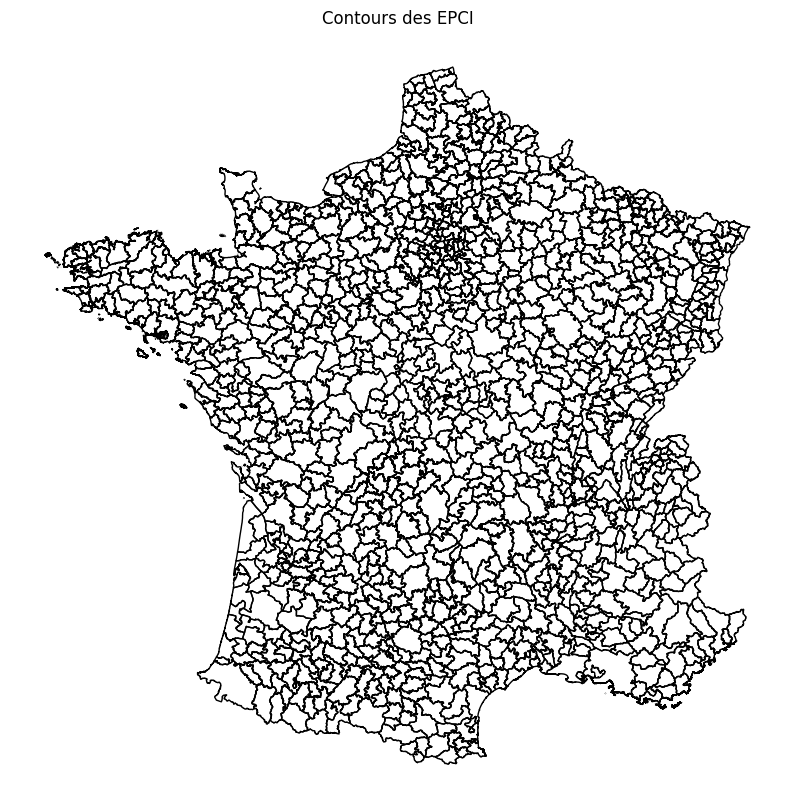

In [9]:
# Vérifier le type des données dans la colonne geometry
print(type(gdf_epci_metropole['geometry'].iloc[0]))

# Si les données sont déjà des objets géométriques, ne pas les convertir
# Sinon, convertir seulement si c'est une chaîne de caractères
def convert_if_string(geom):
    if isinstance(geom, str):
        return wkt.loads(geom)
    return geom

gdf_epci_metropole['geometry'] = gdf_epci_metropole['geometry'].apply(convert_if_string)

# Créer un GeoDataFrame
gdf_epci_metropole = gpd.GeoDataFrame(gdf_epci_metropole, geometry='geometry')

# Tracer les contours des EPCI
fig, ax = plt.subplots(figsize=(10, 10))
gdf_epci_metropole.plot(ax=ax, edgecolor='black', facecolor='none')
plt.title('Contours des EPCI')
plt.axis('off')
plt.show()

In [10]:
gdf_epci_metropole.sample()

,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,MONO_DEP
57,57,200030633,"['Busigny', 'Élincourt', 'Saint-Vaast-en-Cambr...","['59118', '59191', '59547', '59395', '59498', ...","['59', '59', '59', '59', '59', '59', '59', '59...",63789.0,3752.046089,26690.307426,20621.644058,"POLYGON ((721058.8 6990864, 720932.9 6990793.8...",True


In [6]:
# Fonction pour convertir les chaînes de caractères en listes
def convert_to_list(value):
    if isinstance(value, str):
        # Supprime les caractères indésirables et divise la chaîne
        cleaned = value.replace('[', '').replace(']', '').replace("'", '').replace('"', '')
        # Divise la chaîne en éléments individuels
        items = [item.strip() for item in cleaned.split(',') if item.strip()]
        return items
    elif isinstance(value, list):
        return value
    return []

# 2. Définir les tranches de distances
distance_bins = [0, 10, 20, 30, 40, 50, float('inf')]
distance_labels = ['<10km', '<20km', '<30km', '<40km', '<50km', '>50km']

# 3. Définir les catégories de transport
transport_categories = {
    'vert': [1, 2, 3],
    'jaune': [6],
    'rouge': [4, 5]
}

# Créer un dictionnaire pour stocker les résultats
results = {}

In [ ]:
# 1. Convertir les colonnes de codes INSEE en listes
print("Conversion des codes INSEE en listes...")
gdf_epci_metropole['INSEE_COM_list'] = gdf_epci_metropole['INSEE_COM'].apply(convert_to_list)
gdf_epci_metropole['INSEE_DEP_list'] = gdf_epci_metropole['INSEE_DEP'].apply(convert_to_list)

In [24]:
from tqdm import tqdm

# Boucle sur chaque EPCI avec barre de progression
print("Calcul des statistiques par EPCI...")
for idx, epci_row in tqdm(gdf_epci_metropole.iterrows(), total=gdf_epci_metropole.shape[0], desc="Traitement des EPCI"):
    epci_communes = set(epci_row['INSEE_COM_list'])
    epci_code = epci_row['SIREN_EPCI']
    
    results[epci_code] = {}
    
    for transport_name, transport_codes in transport_categories.items():
        transport_data = df_mobpro_brut[df_mobpro_brut['TRANS'].isin(transport_codes)]
        
        entrants = transport_data[
            (~transport_data['DCLT'].isin(epci_communes)) & 
            (transport_data['COMMUNE'].isin(epci_communes))
        ]
        sortants = transport_data[
            (transport_data['DCLT'].isin(epci_communes)) & 
            (~transport_data['COMMUNE'].isin(epci_communes))
        ]
        internes = transport_data[
            (transport_data['DCLT'].isin(epci_communes)) & 
            (transport_data['COMMUNE'].isin(epci_communes))
        ]
        
        for i, (lower, upper) in enumerate(zip(distance_bins[:-1], distance_bins[1:])):
            label = distance_labels[i]
            
            entrants_bin = entrants[(entrants['distance_km'] > lower) & (entrants['distance_km'] <= upper)]
            results[epci_code][f'nb_entrant_{label}_{transport_name}'] = entrants_bin['IPONDI'].sum()
            results[epci_code][f'distance_entrant_{label}_{transport_name}'] = (
                (entrants_bin['distance_km'] * entrants_bin['IPONDI']).sum() / entrants_bin['IPONDI'].sum()
                if entrants_bin['IPONDI'].sum() > 0 else 0
            )
            
            sortants_bin = sortants[(sortants['distance_km'] > lower) & (sortants['distance_km'] <= upper)]
            results[epci_code][f'nb_sortant_{label}_{transport_name}'] = sortants_bin['IPONDI'].sum()
            results[epci_code][f'distance_sortant_{label}_{transport_name}'] = (
                (sortants_bin['distance_km'] * sortants_bin['IPONDI']).sum() / sortants_bin['IPONDI'].sum()
                if sortants_bin['IPONDI'].sum() > 0 else 0
            )
        
        results[epci_code][f'nb_intra_{transport_name}'] = internes['IPONDI'].sum()
        results[epci_code][f'distance_intra_{transport_name}'] = (
            (internes['distance_km'] * internes['IPONDI']).sum() / internes['IPONDI'].sum()
            if internes['IPONDI'].sum() > 0 else 0
        )


Calcul des statistiques par EPCI...


Traitement des EPCI: 100%|██████████| 1225/1225 [1:18:15<00:00,  3.83s/it]


In [28]:

# Convertir les résultats en DataFrame
print("Conversion des résultats en DataFrame...")
results_df = pd.DataFrame.from_dict(results, orient='index')

# Joindre les résultats au GeoDataFrame original
print("Jointure des résultats au GeoDataFrame...")
gdf_epci_metropole_enrichi = gdf_epci_metropole.merge(results_df, left_on='SIREN_EPCI', right_index=True, how='left')

# Afficher un aperçu des colonnes ajoutées
print("\nColonnes ajoutées:")
new_columns = [col for col in gdf_epci_metropole_enrichi.columns if col not in gdf_epci_metropole.columns]
print(f"Nombre de nouvelles colonnes: {len(new_columns)}")
print(new_columns[:10])  # Afficher les 10 premières nouvelles colonnes

print("\nAperçu du GeoDataFrame enrichi:")
print(gdf_epci_metropole_enrichi.head())

# Le GeoDataFrame enrichi est maintenant prêt à être utilisé
# Il contient toutes les statistiques demandées par EPCI


Conversion des résultats en DataFrame...
Jointure des résultats au GeoDataFrame...

Colonnes ajoutées:
Nombre de nouvelles colonnes: 78
['nb_entrant_<10km_vert', 'distance_entrant_<10km_vert', 'nb_sortant_<10km_vert', 'distance_sortant_<10km_vert', 'nb_entrant_<20km_vert', 'distance_entrant_<20km_vert', 'nb_sortant_<20km_vert', 'distance_sortant_<20km_vert', 'nb_entrant_<30km_vert', 'distance_entrant_<30km_vert']

Aperçu du GeoDataFrame enrichi:
   Unnamed: 0 SIREN_EPCI                                                NOM  \
0           0  200000172  ['Marignier', 'Contamine-sur-Arve', 'Glières-V...   
1           1  200000438  ['Crossac', 'Pontchâteau', 'Sainte-Anne-sur-Br...   
2           2  200000545  ['Crancey', 'Saint-Hilaire-sous-Romilly', 'Rom...   
3           3  200000628  ['Lapalud', 'Mondragon', 'Mornas', 'Lamotte-du...   
4           4  200000800  ['Chaumont-sur-Tharonne', 'Chaon', 'Vouzon', '...   

                                           INSEE_COM  \
0  ['74164', '74087

In [29]:
gdf_epci_metropole_enrichi.head()

,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,...,nb_entrant_<50km_rouge,distance_entrant_<50km_rouge,nb_sortant_<50km_rouge,distance_sortant_<50km_rouge,nb_entrant_>50km_rouge,distance_entrant_>50km_rouge,nb_sortant_>50km_rouge,distance_sortant_>50km_rouge,nb_intra_rouge,distance_intra_rouge
0,0,200000172,"['Marignier', 'Contamine-sur-Arve', 'Glières-V...","['74164', '74087', '74212', '74312', '74049', ...","['74', '74', '74', '74', '74', '74', '74']",27218.0,2218.427898,11802.018216,12031.433753,"POLYGON ((967052.3 6556343.9, 967045.7 6556329...",...,23.424631,41.855623,98.852138,45.998058,103.969510,216.047856,271.156739,181.420870,3588.632912,5.668859
1,1,200000438,"['Crossac', 'Pontchâteau', 'Sainte-Anne-sur-Br...","['44050', '44129', '44152', '44098', '44068', ...","['44', '44', '44', '44', '44', '44', '44', '44...",35917.0,2756.235128,15784.280047,14384.550345,"POLYGON ((325044.8 6719783.3, 325064.2 6719753...",...,1102.793630,45.257024,253.071753,45.521902,490.328609,157.114357,187.438224,143.643734,4143.172699,7.481773
2,2,200000545,"['Crancey', 'Saint-Hilaire-sous-Romilly', 'Rom...","['10114', '10341', '10323', '10164', '10220', ...","['10', '10', '10', '10', '10', '10']",18739.0,874.965660,8665.218943,5446.249610,"POLYGON ((751763.4 6819199.7, 751729 6819176.1...",...,32.553518,44.753960,87.961210,44.483349,452.965644,132.967389,175.929027,134.837601,2352.085074,4.782090
3,3,200000628,"['Lapalud', 'Mondragon', 'Mornas', 'Lamotte-du...","['84064', '84078', '84083', '84063', '84019']","['84', '84', '84', '84', '84']",24224.0,1442.982297,10773.779439,7526.326339,"POLYGON ((841785.2 6347339.5, 841574.2 6347339...",...,85.004987,44.079470,104.088887,44.554021,293.441754,192.753391,229.911823,162.979680,3048.432489,5.904768
4,4,200000800,"['Chaumont-sur-Tharonne', 'Chaon', 'Vouzon', '...","['41046', '41036', '41296', '41161', '41106', ...","['41', '41', '41', '41', '41', '41']",10437.0,550.174086,4746.154398,3763.453777,"POLYGON ((631422.5 6721239, 631378 6721141.6, ...",...,151.569186,42.964703,73.995380,43.829028,130.487340,144.713486,138.297036,116.352574,1653.353772,7.436458


In [8]:
epci_features.sample()

,Unnamed: 0.1,Unnamed: 0,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,...,distance_entrant_<50km_rouge,nb_sortant_<50km_rouge,distance_sortant_<50km_rouge,nb_entrant_>50km_rouge,distance_entrant_>50km_rouge,nb_sortant_>50km_rouge,distance_sortant_>50km_rouge,nb_intra_rouge,distance_intra_rouge,cluster
926,955,955,243900479,"['Bellefontaine', 'Morbier', 'Longchaumois', '...","['39047', '39367', '39297', '39368']","['39', '39', '39', '39']",9150.0,722.077491,4238.028466,3635.262981,...,44.237945,35.127,46.048579,64.39993,694.033132,87.401198,282.418502,1260.043248,6.027103,0


In [ ]:
features = [
    # Variables pour le mode "rouge"
    "nb_entrant_<10km_rouge", "distance_entrant_<10km_rouge",
    "nb_sortant_<10km_rouge", "distance_sortant_<10km_rouge",
    "nb_entrant_<20km_rouge", "distance_entrant_<20km_rouge",
    "nb_sortant_<20km_rouge", "distance_sortant_<20km_rouge",
    "nb_entrant_<30km_rouge", "distance_entrant_<30km_rouge",
    "nb_sortant_<30km_rouge", "distance_sortant_<30km_rouge",
    "nb_entrant_<40km_rouge", "distance_entrant_<40km_rouge",
    "nb_sortant_<40km_rouge", "distance_sortant_<40km_rouge",
    "nb_entrant_<50km_rouge", "distance_entrant_<50km_rouge",
    "nb_sortant_<50km_rouge", "distance_sortant_<50km_rouge",
    "nb_entrant_>50km_rouge", "distance_entrant_>50km_rouge",
    "nb_sortant_>50km_rouge", "distance_sortant_>50km_rouge",
    "nb_intra_rouge", "distance_intra_rouge",
    
    # Variables pour le mode "jaune"
    "nb_entrant_<10km_jaune", "distance_entrant_<10km_jaune",
    "nb_sortant_<10km_jaune", "distance_sortant_<10km_jaune",
    "nb_entrant_<20km_jaune", "distance_entrant_<20km_jaune",
    "nb_sortant_<20km_jaune", "distance_sortant_<20km_jaune",
    "nb_entrant_<30km_jaune", "distance_entrant_<30km_jaune",
    "nb_sortant_<30km_jaune", "distance_sortant_<30km_jaune",
    "nb_entrant_<40km_jaune", "distance_entrant_<40km_jaune",
    "nb_sortant_<40km_jaune", "distance_sortant_<40km_jaune",
    "nb_entrant_<50km_jaune", "distance_entrant_<50km_jaune",
    "nb_sortant_<50km_jaune", "distance_sortant_<50km_jaune",
    "nb_entrant_>50km_jaune", "distance_entrant_>50km_jaune",
    "nb_sortant_>50km_jaune", "distance_sortant_>50km_jaune",
    "nb_intra_jaune", "distance_intra_jaune",
    
    # Variables pour le mode "vert"
    "nb_entrant_<10km_vert", "distance_entrant_<10km_vert",
    "nb_sortant_<10km_vert", "distance_sortant_<10km_vert",
    "nb_entrant_<20km_vert", "distance_entrant_<20km_vert",
    "nb_sortant_<20km_vert", "distance_sortant_<20km_vert",
    "nb_entrant_<30km_vert", "distance_entrant_<30km_vert",
    "nb_sortant_<30km_vert", "distance_sortant_<30km_vert",
    "nb_entrant_<40km_vert", "distance_entrant_<40km_vert",
    "nb_sortant_<40km_vert", "distance_sortant_<40km_vert",
    "nb_entrant_<50km_vert", "distance_entrant_<50km_vert",
    "nb_sortant_<50km_vert", "distance_sortant_<50km_vert",
    "nb_entrant_>50km_vert", "distance_entrant_>50km_vert",
    "nb_sortant_>50km_vert", "distance_sortant_>50km_vert",
    "nb_intra_vert", "distance_intra_vert"
]

# Pour voir le nombre total de features
print(f"Nombre total de features: {len(features)}")

Nombre total de features: 78


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Exemple de données : chaque ligne est une ville, chaque colonne une variable ---
data = epci_features

# --- Sélection des variables à utiliser ---
selected_vars = features + ['Nb actifs occupés en 2021', ]  # On choisit les variables pertinentes
X = data[selected_vars].copy()  # On extrait les données

# --- Normalisation des données ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Mise à l'échelle pour équilibrer les unités

# --- Application du K-Means ---
k = 10  # Nombre de clusters (à adapter selon l'analyse)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_scaled)  # Ajout des clusters au DataFrame

# --- Affichage des résultats ---
print(data[['SIREN_EPCI', 'cluster']])

/tmp/ipykernel_74820/1676334617.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_kmeans['ratio_sortant_entrant'].fillna(0, inplace=True)


Nombre de valeurs manquantes par colonne:
nb_actifs                             0
distance_totale_entrant_<10km_vert    0
distance_totale_sortant_<10km_vert    0
nb_entrant_<10km_vert                 0
nb_sortant_<10km_vert                 0
                                     ..
nb_entrant_>50km_rouge                0
nb_sortant_>50km_rouge                0
distance_totale_intra_rouge           0
nb_intra_rouge                        0
ratio_sortant_entrant                 0
Length: 80, dtype: int64
Répartition des EPCI dans les clusters:
0    819
1      1
2     14
3     37
4      6
5     35
6    301
7      8
8      3
9      1
Name: count, dtype: int64


TypeError: agg function failed [how->mean,dtype->object]